In [1]:
using PauliPropagation
using Base.Threads
using Plots

Precompiling PauliPropagation
  ✓ PauliPropagation
  1 dependency successfully precompiled in 2 seconds. 13 already precompiled.


In [13]:
tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_extrapolated));


google_vals = [1, 0.9957248494988796,0.9785691808859784,0.9227771228638144,0.8549387301071374,
    0.7790027681081058,0.6093954499261214,0.4257824480390532,0.2090085348069826,0.0116245678393245, -4.8872551798147e-09]
google_angles = [0.000, 0.100, 0.200, 0.300, 0.400,0.500,0.600,0.700,0.800,1.000,1.571]

11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 1.0
 1.571

In [3]:
function kickedisingcircuit(nq, nl; topology=nothing)
    
    # just in case a topology is not provided
    if isnothing(topology)
        topology = bricklayertopology(nq)
    end
    
    # define a layer of parametrized Rx-gates
    xlayer(circuit) = append!(circuit, (PauliGate([:X], [qind]) for qind in 1:nq))
    
    # define a layer of fixed ZZ(π/2)-gates
    zzlayer(circuit) = append!(circuit, (PauliGate([:Z, :Z], pair, π/2) for pair in topology))
    
    # define the empty circuit
    circuit = Gate[]
    # append to the circuit
    for _ in 1:nl
        zzlayer(circuit)
        xlayer(circuit)
    end
    tofastgates!(circuit)
    return circuit
end

kickedisingcircuit (generic function with 1 method)

In [4]:
# number of qubits
nq = 127
# the IBM Eagle topology
topology = ibmeagletopology
# 20 layers for the hardest simulation
nl = 20
# create the circuit
const circuit = kickedisingcircuit(nq, nl; topology);
# count the number of parameters
const nparams = countparameters(circuit)
# define the observable (note the index is 62 if you start with 0)
const pstr = PauliString(nq, :Z, 63)

PauliString(nqubits: 127, 1.0 * IIIIIIIIIIIIIIIIIIII...)

In [5]:
# perform the simulation for one x-angle
function onesimulation(angle; min_abs_coeff=0, max_weight=Inf)
    # set the angles of the Rx gates
    thetas = ones(nparams) * angle
    # propagate
    psum = propagate(circuit, pstr, thetas; min_abs_coeff, max_weight)
    # overlap with the zero-state
    return overlapwithzero(psum)
end

onesimulation (generic function with 1 method)

In [18]:
# set the truncations
min_abs_coeff = 1e-5
max_weight = 8

# prepare everything and run
x_angles = LinRange(0, π/2, 20)
expectations = zeros(length(x_angles))
t = @timed @threads for ii in eachindex(x_angles)
    angle = x_angles[ii]
    @time expectations[ii] = onesimulation(angle; min_abs_coeff, max_weight)
end

print("Total simulation time: ", t.time, " seconds")

  0.000594 seconds (75.69 k allocations: 2.845 MiB)
  0.001123 seconds (188.52 k allocations: 6.019 MiB)
  0.011373 seconds (1.78 M allocations: 57.043 MiB)
  0.095879 seconds (5.14 M allocations: 167.142 MiB, 52.47% gc time)
  0.138132 seconds (9.30 M allocations: 282.092 MiB, 36.42% gc time)
  0.305396 seconds (23.54 M allocations: 738.158 MiB, 16.47% gc time)
  0.686434 seconds (34.38 M allocations: 1.024 GiB, 46.89% gc time)
  2.425538 seconds (95.21 M allocations: 2.730 GiB, 47.86% gc time)
  3.602747 seconds (164.23 M allocations: 4.821 GiB, 41.16% gc time)
  4.005889 seconds (193.77 M allocations: 5.658 GiB, 37.01% gc time)
  0.586579 seconds (44.79 M allocations: 1.287 GiB)
  5.771826 seconds (237.94 M allocations: 6.584 GiB, 33.53% gc time)
 12.835304 seconds (481.82 M allocations: 13.685 GiB, 39.16% gc time)
 13.235513 seconds (506.35 M allocations: 14.395 GiB, 37.97% gc time)
  7.896408 seconds (220.31 M allocations: 6.393 GiB, 39.95% gc time)
 22.089218 seconds (732.95 M al

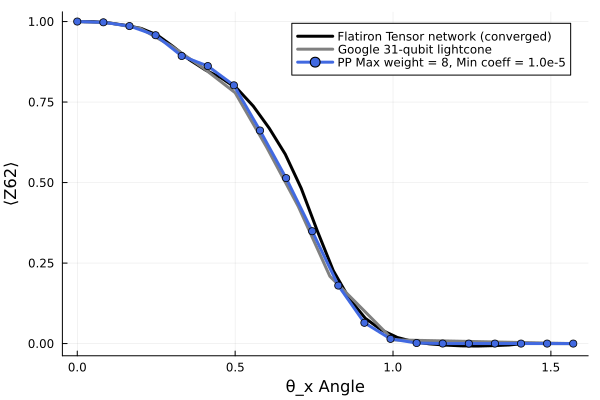

In [19]:
pl = plot(xlabel="θ_x Angle", ylabel="⟨Z62⟩")
plot!(tn_angles, tn_vals, label="Flatiron Tensor network (converged)", color="black", linewidth=3)
plot!(google_angles, google_vals, label="Google 31-qubit lightcone", color="grey", linewidth=3)
plot!(x_angles, expectations, marker=:circle, label="PP Max weight = $max_weight, Min coeff = $min_abs_coeff", linewidth=3, color="royalblue")
